# Import model

In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [2]:
# Global variables
SAVE = False
SEED = 42

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
N_TYPES = len(CLASS_TYPES)

# Processing data

In [3]:
# Function for inporting data           
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels

In [4]:
# Setting up file paths for training and testing
USER_PATH = r"datasets"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 27188
Number of Labels: 27188

Testing
Number of Paths: 6796
Number of Labels: 6796


Training Counts
{'MildDemented': 7168, 'ModerateDemented': 5172, 'NonDemented': 7680, 'VeryMildDemented': 7168}

Testing Counts
{'MildDemented': 1792, 'ModerateDemented': 1292, 'NonDemented': 1920, 'VeryMildDemented': 1792}


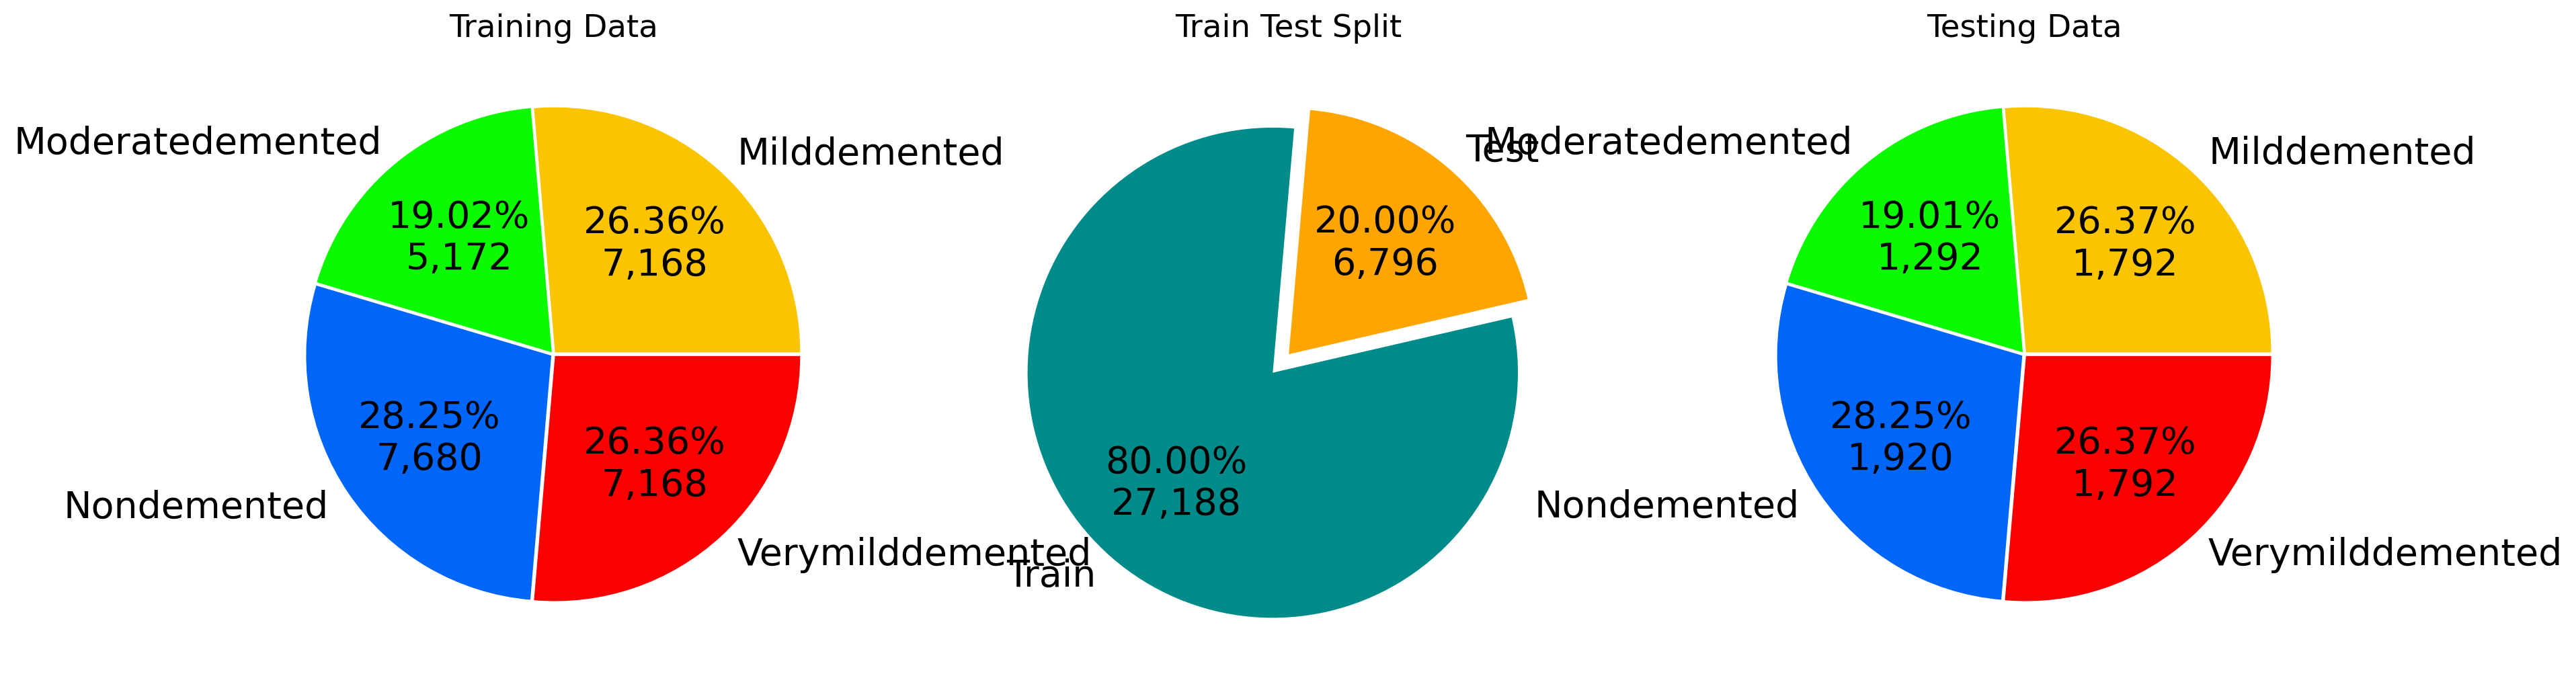

In [5]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  # Explode the slices slightly for better visualization
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)


plt.show()

x reshaped: (1, 150, 150, 3)


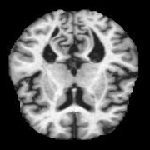

In [6]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [7]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()

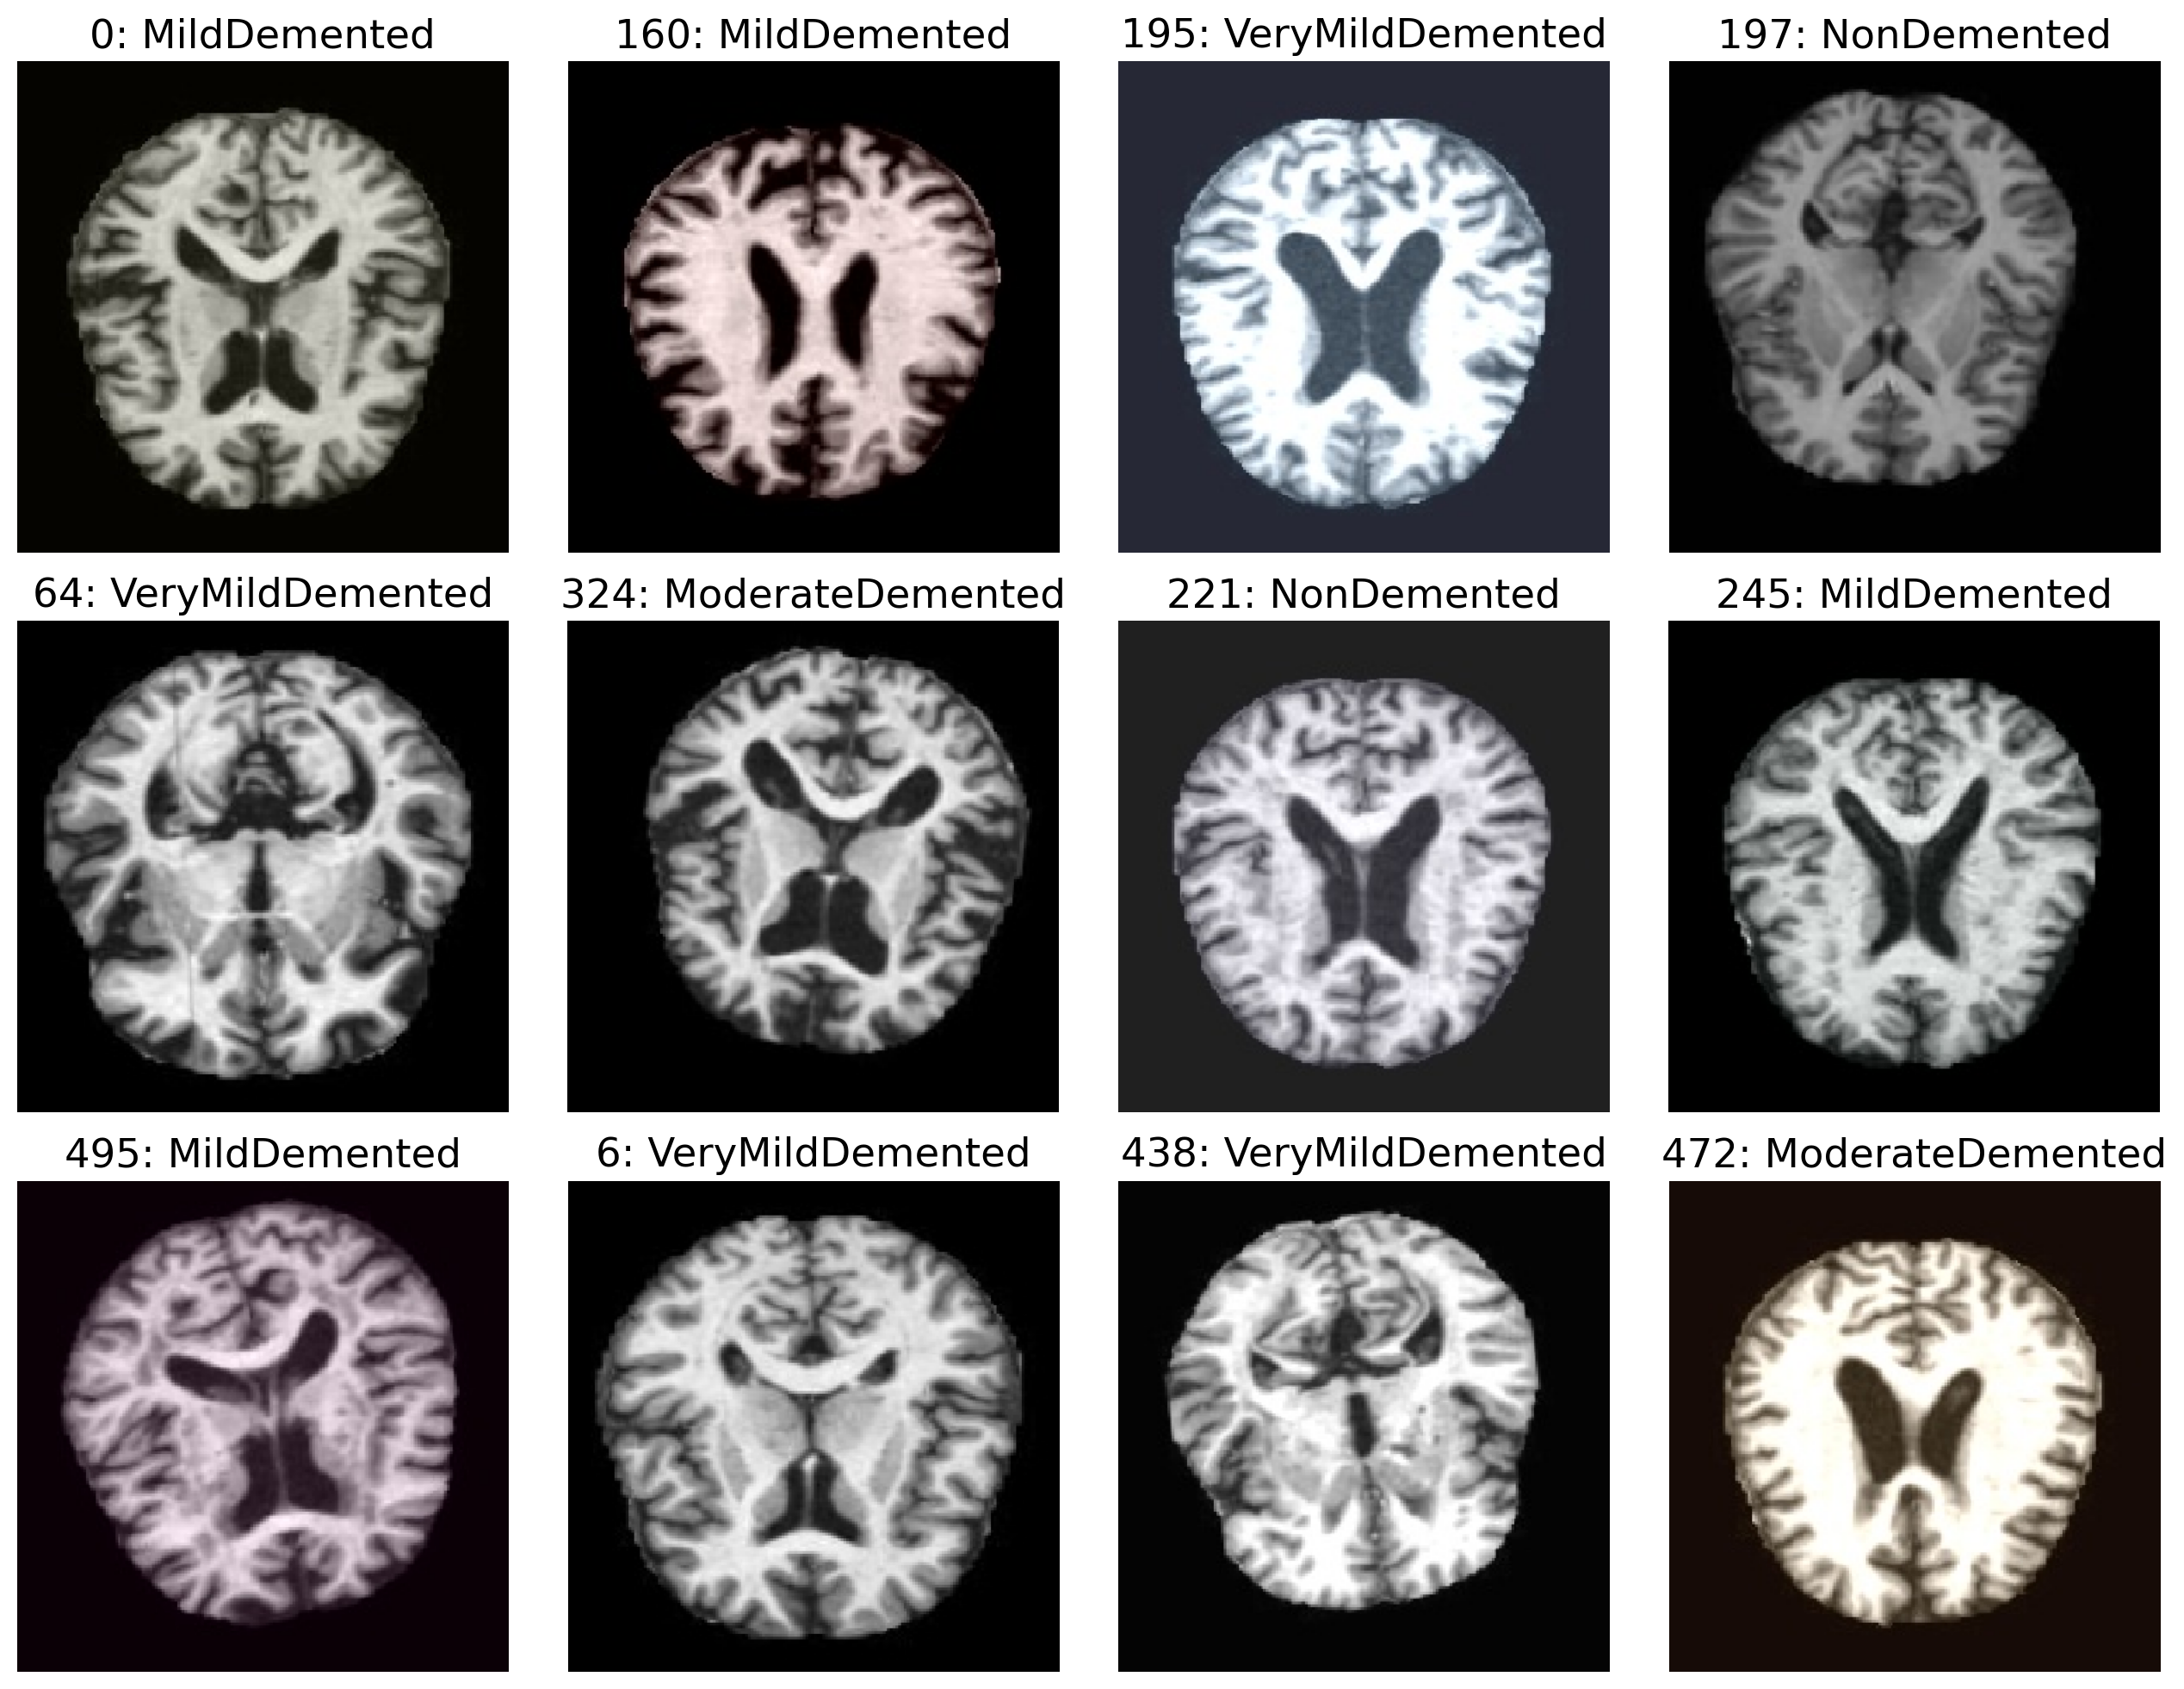

In [8]:
show_images(train_paths, 
            train_labels, 
            index_list=[0, 160, 195, 197,
                        64, 324, 221, 245,
                        495, 6, 438, 472], 
            im_size=350, 
            figsize=(13,10),
            save=SAVE)

# Keras model

In [9]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [10]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [11]:
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [12]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """
    
    # Generate augmented samples
    augmented_samples = train_generator.next()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        
    plt.tight_layout()
        
    if save:
        plt.savefig('show_ImageDataGenerator.pdf')
        
    plt.show()

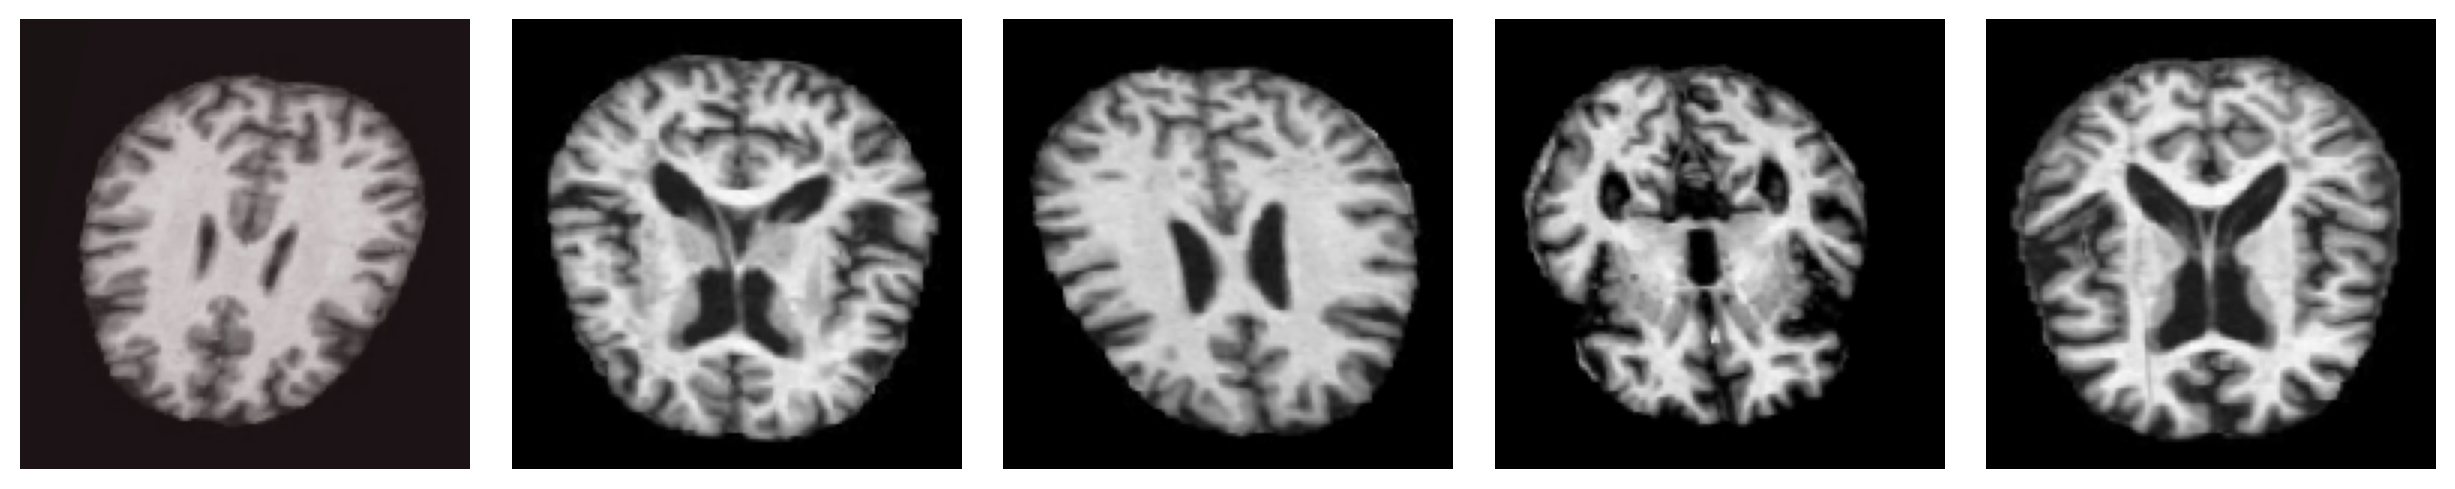

In [13]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=SAVE)

In [15]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 10

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 10
Batch size: 32
Steps Per Epoch: 849
Validation steps: 212


# Simple model

In [16]:
# Define the model architecture
model_1 = models.Sequential()

# Convolutional layer 1
model_1.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_1.add(Conv2D(64, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(Flatten())

# Full connect layers
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.5, seed=SEED))
model_1.add(Dense(N_TYPES, activation="softmax"))

model_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)        

# Callbacks

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0)
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# The second advanced model

In [18]:
model_2 = models.Sequential()

# Convolutional layer 1
model_2.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_2.add(Conv2D(64, (4, 4), activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_2.add(Conv2D(128, (4, 4), activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3))) #

# Convolutional layer 4
model_2.add(Conv2D(128, (4, 4), activation="relu"))
model_2.add(Flatten())

# Full connect layers
model_2.add(Dense(512, activation="relu"))
model_2.add(Dropout(0.5, seed=SEED))
model_2.add(Dense(N_TYPES, activation="softmax"))

model_2.summary()


optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 128)        

In [19]:
# Stop training if loss doesn't keep decreasing.
model_2_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_2_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history_2 = model_2.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=validation_steps,
                        callbacks=[model_2_es, model_2_rlr])

Epoch 1/10


849/849 [==============================] - 1821s 2s/step - loss: 1.1474 - accuracy: 0.4307 - val_loss: 0.7673 - val_accuracy: 0.6347 - lr: 0.0010
Epoch 2/10
849/849 [==============================] - 1708s 2s/step - loss: 0.7548 - accuracy: 0.6468 - val_loss: 0.6643 - val_accuracy: 0.6930 - lr: 0.0010
Epoch 3/10
849/849 [==============================] - 1686s 2s/step - loss: 0.6831 - accuracy: 0.6820 - val_loss: 0.6140 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 4/10
849/849 [==============================] - 1759s 2s/step - loss: 0.6327 - accuracy: 0.7091 - val_loss: 0.5627 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 5/10
849/849 [==============================] - 1777s 2s/step - loss: 0.5879 - accuracy: 0.7306 - val_loss: 0.5238 - val_accuracy: 0.7591 - lr: 0.0010
Epoch 6/10
358/849 [===========>..................] - ETA: 15:11 - loss: 0.5594 - accuracy: 0.7507

# Save model

In [19]:
# save model in .json and .h5
model_json = model_2.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model_2.save_weights("model.h5")